<a href="https://colab.research.google.com/github/carrot1301/Financial-Econometrics-Projects/blob/main/Macro_Risk_Quantification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Góc phần tư (Quadrant): Economic & Inflation (Kinh tế & Lạm phát).

Lựa chọn biến theo vòng tròn (Concentric Circles):

Biến 1 - Mild-Tier Change (Vòng tròn giữa - Thay đổi vừa phải): Energy Cost Push (Áp lực chi phí năng lượng).

* Dữ liệu đại diện: Giá Dầu thô WTI (Crude Oil Futures - Symbol: CL=F).

* Lý do: Giá hàng hóa cơ bản biến động dựa trên cung cầu vật lý, thường có độ trễ và quán tính nhất định.

Biến 2 - Larger Change (Vòng tròn ngoài - Thay đổi lớn): Sector Equity Valuation (Định giá cổ phiếu ngành).

* Dữ liệu đại diện: Quỹ ETF Năng lượng (Energy Select Sector SPDR - Symbol: XLE).

* Lý do: Thị trường chứng khoán thường phản ứng mạnh hơn (quá mức) so với giá hàng hóa do tâm lý nhà đầu tư và đòn bẩy tài chính của các công ty.

CÀI ĐẶT THƯ VIỆN

In [1]:
!pip install yfinance statsmodels seaborn matplotlib --quiet

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import skew, kurtosis

plt.style.use('seaborn-v0_8')
pd.set_option('display.float_format', lambda x: '%.4f' % x)
print("Setup complete. Ready to fetch data.")

Setup complete. Ready to fetch data.


THU THẬP & CHUYỂN ĐỔI DỮ LIỆU

- Stationarity (Tính dừng): Chuỗi giá ($P_t$) thường có xu hướng tăng theo thời gian (không dừng), làm sai lệch các kiểm định thống kê. Chuỗi lợi suất ($r_t$) thường dao động quanh 0 (có tính dừng), phù hợp để chạy hồi quy.
- Normalization: Giúp so sánh được hai tài sản có mệnh giá khác nhau (ví dụ: Giá dầu 70 USD vs ETF giá 90 USD).

In [4]:
# 1. Định nghĩa mã chứng khoán (Tickers)
# CL=F: Crude Oil (Macro Factor - X)
# XLE: Energy ETF (Sensitive Asset - Y)
tickers = ['CL=F', 'XLE']

# 2. Tải dữ liệu (Minimum 5 years)
start_date = '2019-01-01'
end_date = '2024-01-01'
print("Downloading data...")
raw_data = yf.download(tickers, start=start_date, end=end_date)['Close']

# Xử lý dữ liệu thiếu (Drop NA)
raw_data = raw_data.dropna()

# 3. Chuyển đổi sang Log Returns (Data Transformation)
# Công thức: ln(Pt / Pt-1)
log_returns = np.log(raw_data / raw_data.shift(1)).dropna()

# Đổi tên cột cho rõ ràng (Xử lý trường hợp Yahoo xếp thứ tự ngẫu nhiên)
if 'CL=F' in raw_data.columns:
    mapping = {'CL=F': 'Oil_Returns (X)', 'XLE': 'Energy_ETF_Returns (Y)'}
    log_returns = log_returns.rename(columns=mapping)

print("\n--- 5 Dòng đầu tiên của dữ liệu Lợi suất (Log Returns) ---")
print(log_returns.head())

/tmp/ipython-input-1668683299.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  2 of 2 completed


--- 5 Dòng đầu tiên của dữ liệu Lợi suất (Log Returns) ---
Ticker      Oil_Returns (X)  Energy_ETF_Returns (Y)
Date                                               
2019-01-03           0.0117                 -0.0100
2019-01-04           0.0183                  0.0335
2019-01-07           0.0116                  0.0148
2019-01-08           0.0256                  0.0077
2019-01-09           0.0505                  0.0157



/usr/local/lib/python3.12/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


PHÂN TÍCH THỐNG KÊ MÔ TẢ

- Volatility (Std Dev): Đo lường rủi ro. So sánh xem Dầu hay ETF biến động mạnh hơn.

- Skewness: Nếu âm (< 0), tài sản có rủi ro sụt giảm mạnh (Crash risk).

- Kurtosis: Nếu > 3 (Leptokurtic), phân phối có "đuôi dày" (Fat tails). Nghĩa là xác suất xảy ra các sự kiện cực đoan (khủng hoảng) cao hơn so với phân phối chuẩn lý thuyết.

In [5]:
# Tính toán các chỉ số thống kê mô tả
desc_stats = log_returns.describe().T
desc_stats['skewness'] = log_returns.skew()
desc_stats['kurtosis'] = log_returns.kurtosis()

# Chỉ lấy các cột quan trọng theo yêu cầu
final_stats = desc_stats[['mean', 'std', 'skewness', 'kurtosis']]

print("\n--- Bảng Thống kê Mô tả (Descriptive Statistics Table) ---")
print(final_stats)

print("\n--- Giải thích nhanh ---")
print("1. Mean: Trung bình lợi suất ngày.")
print("2. Std (Volatility): Độ lệch chuẩn, đo lường rủi ro biến động.")
print("3. Skewness: Độ lệch. Âm = rủi ro giảm giá mạnh (Left tail).")
print("4. Kurtosis: Độ nhọn. > 3 = 'Fat tails' (Rủi ro sự kiện cực đoan cao).")


--- Bảng Thống kê Mô tả (Descriptive Statistics Table) ---
                         mean    std  skewness  kurtosis
Ticker                                                  
Oil_Returns (X)        0.0008 0.0341    0.0592   22.9991
Energy_ETF_Returns (Y) 0.0005 0.0232   -0.9168   13.3242

--- Giải thích nhanh ---
1. Mean: Trung bình lợi suất ngày.
2. Std (Volatility): Độ lệch chuẩn, đo lường rủi ro biến động.
3. Skewness: Độ lệch. Âm = rủi ro giảm giá mạnh (Left tail).
4. Kurtosis: Độ nhọn. > 3 = 'Fat tails' (Rủi ro sự kiện cực đoan cao).


PHÂN TÍCH TƯƠNG QUAN

- Covariance: Cho biết chiều hướng (cùng dấu dương là cùng tăng).

- Correlation: Cho biết độ mạnh yếu (từ -1 đến +1). Với Dầu và Năng lượng, ta kỳ vọng tương quan dương mạnh (> 0.5).

Covariance: 0.000422 (Chỉ chiều hướng)
Correlation Coefficient: 0.5345 (Chỉ độ mạnh và chiều hướng)


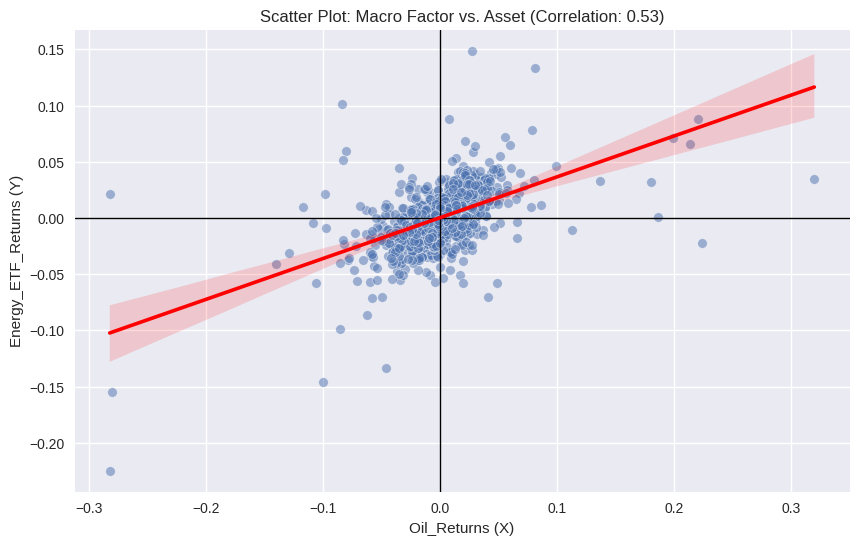

In [6]:
# Tính Covariance và Correlation
cov_matrix = log_returns.cov()
corr_matrix = log_returns.corr()

asset_y = 'Energy_ETF_Returns (Y)'
asset_x = 'Oil_Returns (X)'

covariance = cov_matrix.loc[asset_x, asset_y]
correlation = corr_matrix.loc[asset_x, asset_y]

print(f"Covariance: {covariance:.6f} (Chỉ chiều hướng)")
print(f"Correlation Coefficient: {correlation:.4f} (Chỉ độ mạnh và chiều hướng)")

# Vẽ biểu đồ Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=log_returns[asset_x], y=log_returns[asset_y], alpha=0.5)
plt.title(f'Scatter Plot: Macro Factor vs. Asset (Correlation: {correlation:.2f})')
plt.xlabel('Macro Factor: Crude Oil Returns (X)')
plt.ylabel('Asset: Energy ETF Returns (Y)')
plt.axhline(0, color='black', lw=1)
plt.axvline(0, color='black', lw=1)
# Vẽ đường xu hướng (Trendline)
sns.regplot(x=log_returns[asset_x], y=log_returns[asset_y], scatter=False, color='red')
plt.show()

MÔ HÌNH HỒI QUY TUYẾN TÍNH

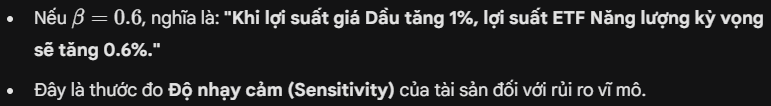

In [7]:
# Định nghĩa biến X và Y
X = log_returns[asset_x]
Y = log_returns[asset_y]

# Thêm hằng số (Intercept) vào biến X (Bắt buộc trong statsmodels)
X_const = sm.add_constant(X)

# Chạy mô hình OLS
model = sm.OLS(Y, X_const).fit()

print("\n--- KẾT QUẢ MÔ HÌNH HỒI QUY (OLS RESULTS) ---")
print(model.summary())

# Trích xuất hệ số để giải thích
beta = model.params[asset_x]
print(f"\nSlope Coefficient (Beta): {beta:.4f}")
print("Ý nghĩa kinh tế: Hệ số này đo lường độ nhạy cảm (Sensitivity) của ETF đối với giá Dầu.")


--- KẾT QUẢ MÔ HÌNH HỒI QUY (OLS RESULTS) ---
                              OLS Regression Results                              
Dep. Variable:     Energy_ETF_Returns (Y)   R-squared:                       0.286
Model:                                OLS   Adj. R-squared:                  0.285
Method:                     Least Squares   F-statistic:                     501.2
Date:                    Wed, 17 Dec 2025   Prob (F-statistic):           1.20e-93
Time:                            19:01:43   Log-Likelihood:                 3155.6
No. Observations:                    1255   AIC:                            -6307.
Df Residuals:                        1253   BIC:                            -6297.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

KIỂM ĐỊNH TÍNH DỪNG

Lý thuyết:
- H0 (Null Hypothesis): Chuỗi dữ liệu có nghiệm đơn vị (Non-stationary / Không dừng).
- Decision: Nếu p-value < 0.05 --> Bác bỏ H0 --> Dữ liệu Dừng (Tốt).
- Nếu không dừng, mô hình hồi quy sẽ bị coi là vô nghĩa (Spurious).

--- Kiểm định Augmented Dickey-Fuller (ADF) cho biến Y ---
ADF Statistic: -9.5081
p-value: 0.0000
=> KẾT LUẬN: Bác bỏ H0. Chuỗi dữ liệu CÓ TÍNH DỪNG (Stationary). Đủ điều kiện chạy hồi quy.


<Figure size 1000x400 with 0 Axes>

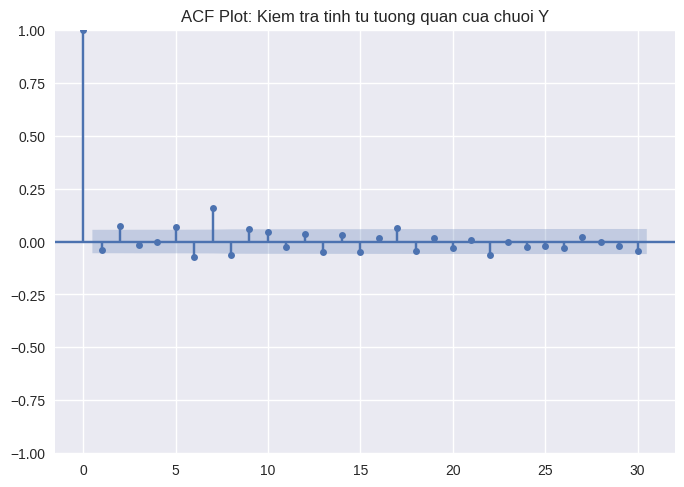

In [12]:
print("--- Kiểm định Augmented Dickey-Fuller (ADF) cho biến Y ---")
adf_result = adfuller(Y)

print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")

if adf_result[1] < 0.05:
    print("=> KẾT LUẬN: Bác bỏ H0. Chuỗi dữ liệu CÓ TÍNH DỪNG (Stationary). Đủ điều kiện chạy hồi quy.")
else:
    print("=> KẾT LUẬN: Chấp nhận H0. Chuỗi dữ liệu KHÔNG DỪNG (Non-Stationary).")

# Vẽ biểu đồ Tự tương quan (ACF Plot)
plt.figure(figsize=(10, 4))
plot_acf(Y, lags=30, title='ACF Plot: Kiem tra tinh tu tuong quan cua chuoi Y')
plt.show()

ĐÁNH GIÁ GIỚI HẠN MÔ HÌNH

R-squared: Tỷ lệ % biến động của Y được giải thích bởi X.

Residual Plot:

- Nếu các điểm phân bố ngẫu nhiên: Tốt.

- Nếu có hình mẫu rõ ràng (ví dụ: hình phễu loe ra): Vi phạm giả định (Heteroscedasticity). Điều này thường thấy trong tài chính (biến động chùm - volatility clustering), là một giới hạn của mô hình OLS đơn giản.

R-squared: 0.2857
Giải thích: 28.57% biến động của ETF Năng lượng được giải thích bởi giá Dầu.


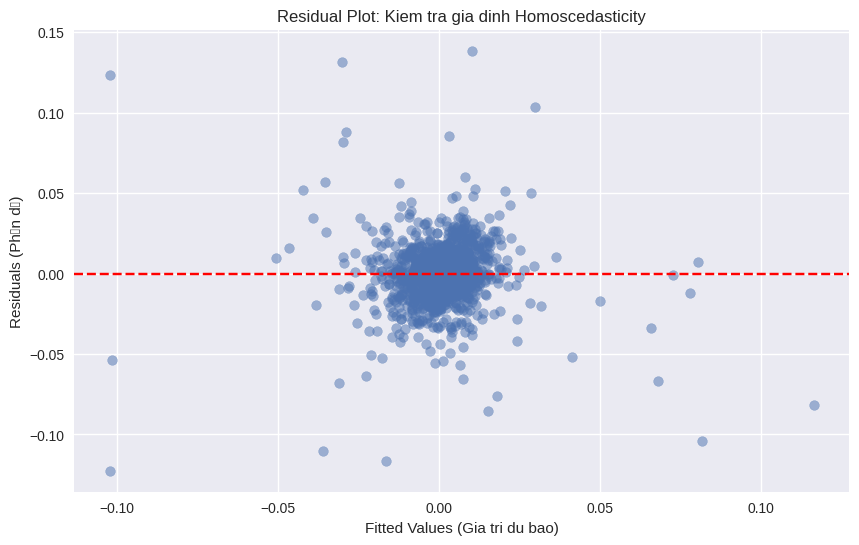


--- Limitation Discussion (Causation vs Correlation) ---
QUAN TRỌNG: Kết quả hồi quy chỉ cho thấy mối quan hệ thống kê (Correlation).
Nó KHÔNG chứng minh rằng giá Dầu là nguyên nhân duy nhất làm giá ETF thay đổi (Causation).
Cả hai có thể cùng bị tác động bởi một yếu tố thứ 3 (VD: Tăng trưởng kinh tế toàn cầu).


In [11]:
# 1. Đánh giá độ phù hợp (R-squared)
r_sq = model.rsquared
print(f"R-squared: {r_sq:.4f}")
print(f"Giải thích: {r_sq*100:.2f}% biến động của ETF Năng lượng được giải thích bởi giá Dầu.")

# 2. Kiểm tra giả định OLS qua đồ thị phần dư (Residual Plot)
residuals = model.resid
fitted_vals = model.fittedvalues

plt.figure(figsize=(10, 6))
plt.scatter(fitted_vals, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot: Kiem tra gia dinh Homoscedasticity')
plt.xlabel('Fitted Values (Gia tri du bao)')
plt.ylabel('Residuals (Phần dư)')
plt.show()

print("\n--- Limitation Discussion (Causation vs Correlation) ---")
print("QUAN TRỌNG: Kết quả hồi quy chỉ cho thấy mối quan hệ thống kê (Correlation).")
print("Nó KHÔNG chứng minh rằng giá Dầu là nguyên nhân duy nhất làm giá ETF thay đổi (Causation).")
print("Cả hai có thể cùng bị tác động bởi một yếu tố thứ 3 (VD: Tăng trưởng kinh tế toàn cầu).")